<h1>Introduction

Midnight Diner (深夜食堂, Shinya shokudō) is a Japanese anthology TV series based on the manga of the same name by Yarō Abe. The show focuses on a midnight diner, the chef, known only as "The Master", and his involvement with his customers.

The setting of Midnight Diner is a small 12 seat Izakaya called "Meshiya" in Shinjuku, Tokyo. Despite the restaurant's strange opening hours, 12 am to 7 am, it is popular with the busy nightlife of Shinjuku. The Shinjuku setting, and the hours of operation, means that much of the Midnight Diner story takes place at night.

The show was well received when it started streaming on Netflix. It has an IMDB rating of 8.4.

The popularity of the show inspired one business man to open a midnight diner in New York. This report aims to find the best location for such a diner. The selected location must be in a neighborhood with active night life scene, and maybe with some asian culture influences.



<h1>Data

New York has a total of 5 boroughs and 306 neighborhoods. For NY geolocation data, I will use the same dataset used in the labs; available at https://geo.nyu.edu/catalog/nyu_2451_34572 or https://ibm.box.com/shared/static/fbpwbovar7lf8p5sgddm06cgipa2rxpe.json

In [1]:
!wget -q -O 'newyork_data.json' https://ibm.box.com/shared/static/fbpwbovar7lf8p5sgddm06cgipa2rxpe.json
print('Data downloaded!')

Data downloaded!


I will also use Foursquare API to get information about night life venues in New York. Similar to the lab, the explore end point will be used but now the category will be specific to night life.

<h1>Code and Analysis

<h2> Import Libaraies and Dependencies

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib.pyplot as plt
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # install folium
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1f             |       h516909a_0         2.1 MB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    certifi-2019.11.28         |   py36h9f0ad1d_1         149 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    ------------------------------------------------------------
                       

<h2>Prepare Neighborhood Dataframe

In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [4]:
neighborhoods_data = newyork_data['features']

In [5]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [6]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [7]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


Now we have all needed neighbourhood data and coordinates in a pd dataframe.
As you can see, NY has 5 boroughs and 306 neighborhoods.

<h3>Visualise the Neighborhoods

In [9]:
#get NY coordinates using geopy

address = 'New York City, NY'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:5: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.


The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [10]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.9,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

<h3>Focus on Manhattan

In [11]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head(40)

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688
5,Manhattan,Manhattanville,40.816934,-73.957385
6,Manhattan,Central Harlem,40.815976,-73.943211
7,Manhattan,East Harlem,40.792249,-73.944182
8,Manhattan,Upper East Side,40.775639,-73.960508
9,Manhattan,Yorkville,40.775930,-73.947118


In [12]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(manhattan_data['Borough'].unique()),
        manhattan_data.shape[0]
    )
)

The dataframe has 1 boroughs and 40 neighborhoods.


In [13]:
manhattan_data.dtypes

Borough          object
Neighborhood     object
Latitude        float64
Longitude       float64
dtype: object

In [14]:
address = 'Manhattan, NY'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  app.launch_new_instance()


The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


In [15]:
# create map of Manhattan using latitude and longitude values
f = folium.Figure(width=800, height=350)
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
f.add_child(map_manhattan)

<h2>Use Foursquare API to analyse Nightlife in NY

In [16]:
# Define API credentials

CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: CNOJXUEFMTH35SOTYBBG5JTMBJNVAFAPQMJAPE1ZVSH2FWT4
CLIENT_SECRET:EP5VZNNEZHGAURWMFQXFNZ3TVYQV1XONPAYJFJJ5BYB0HBSF


Nightlife spot category ID: 4d4b7105d754a06376d81259
Asian Resturants category ID: 4bf58dd8d48988d142941735


In [17]:
def get_venues_count(lat, long, radius, categoryId):
    explore_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION,
                lat,
                long,
                radius,
                categoryId)

    # make the GET request
    return requests.get(explore_url).json()['response']['totalResults']

In [18]:
categories_list=[('Nightlife Spot','4d4b7105d754a06376d81259'), ('Asian Resturants','4bf58dd8d48988d142941735')]

In [19]:
categories_list

[('Nightlife Spot', '4d4b7105d754a06376d81259'),
 ('Asian Resturants', '4bf58dd8d48988d142941735')]

In [20]:
#Create new dataframe to store venues data
manhattan_venues_df = manhattan_data.copy()
for c in categories_list:
    manhattan_venues_df[c[0]] = 0

In [21]:
manhattan_venues_df.head()

,Borough,Neighborhood,Latitude,Longitude,Nightlife Spot,Asian Resturants
0,Manhattan,Marble Hill,40.876551,-73.910660,0,0
1,Manhattan,Chinatown,40.715618,-73.994279,0,0
2,Manhattan,Washington Heights,40.851903,-73.936900,0,0
3,Manhattan,Inwood,40.867684,-73.921210,0,0
4,Manhattan,Hamilton Heights,40.823604,-73.949688,0,0


In [22]:
manhattan_venues_df.shape

(40, 6)

In [23]:
#Request number of venues, store result as CSV
for i, row in manhattan_venues_df.iterrows():
    print(i)
    for c in categories_list:        
        manhattan_venues_df.loc[i, c[0]] = get_venues_count(manhattan_venues_df.Latitude.iloc[i],manhattan_venues_df.Longitude.iloc[i], radius=1000, categoryId=c[1])
    manhattan_venues_df.to_csv('manhattan_venues.csv')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [25]:
#Read already stored CSV
manhattan_venues_df = pd.read_csv('manhattan_venues.csv', index_col=0)
manhattan_venues_df

,Borough,Neighborhood,Latitude,Longitude,Nightlife Spot,Asian Resturants
0,Manhattan,Marble Hill,40.876551,-73.910660,9,19
1,Manhattan,Chinatown,40.715618,-73.994279,134,241
2,Manhattan,Washington Heights,40.851903,-73.936900,16,26
3,Manhattan,Inwood,40.867684,-73.921210,35,22
4,Manhattan,Hamilton Heights,40.823604,-73.949688,22,40
5,Manhattan,Manhattanville,40.816934,-73.957385,18,41
6,Manhattan,Central Harlem,40.815976,-73.943211,24,34
7,Manhattan,East Harlem,40.792249,-73.944182,15,50
8,Manhattan,Upper East Side,40.775639,-73.960508,80,101
9,Manhattan,Yorkville,40.775930,-73.947118,77,108


In [26]:
manhattan_venues_df.sort_values(by='Nightlife Spot',ascending=False).head()

,Borough,Neighborhood,Latitude,Longitude,Nightlife Spot,Asian Resturants
31,Manhattan,Noho,40.723259,-73.988434,245,227
18,Manhattan,Greenwich Village,40.726933,-73.999914,242,179
23,Manhattan,Soho,40.722184,-74.000657,220,232
16,Manhattan,Murray Hill,40.748303,-73.978332,206,219
38,Manhattan,Flatiron,40.739673,-73.990947,206,222


Text(0.5, 1.0, "Manhattan's Nightlife Scene")

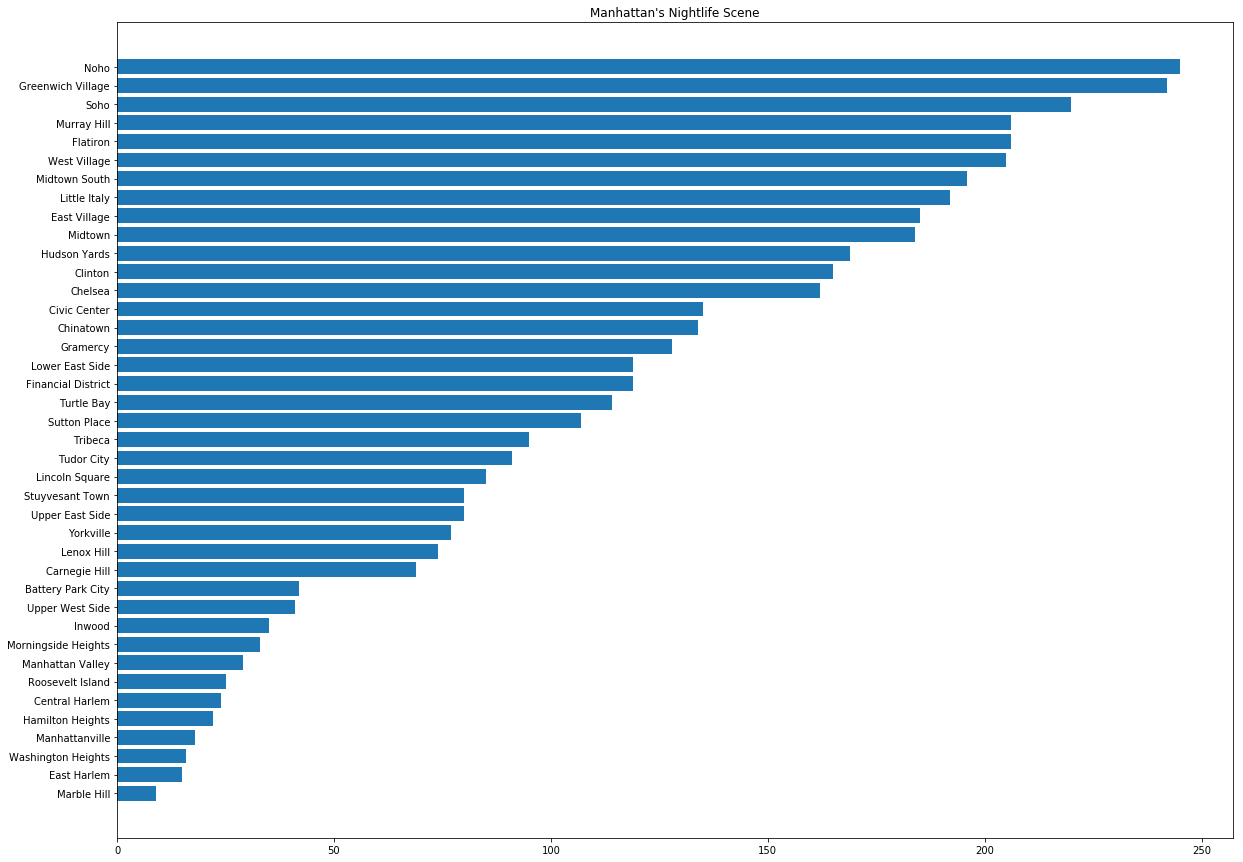

In [27]:
manhattan_venues_df.sort_values(by='Nightlife Spot',inplace=True)
plt.figure(figsize=(20,15))
plt.barh(manhattan_venues_df['Neighborhood'],manhattan_venues_df['Nightlife Spot'])
plt.title('Manhattan\'s Nightlife Scene')

In [28]:
manhattan_venues_df.sort_values(by='Asian Resturants',ascending=False).head()

,Borough,Neighborhood,Latitude,Longitude,Nightlife Spot,Asian Resturants
1,Manhattan,Chinatown,40.715618,-73.994279,134,241
23,Manhattan,Soho,40.722184,-74.000657,220,232
33,Manhattan,Midtown South,40.748510,-73.988713,196,229
31,Manhattan,Noho,40.723259,-73.988434,245,227
38,Manhattan,Flatiron,40.739673,-73.990947,206,222


Text(0.5, 1.0, "Manhattan's Asian Resturants")

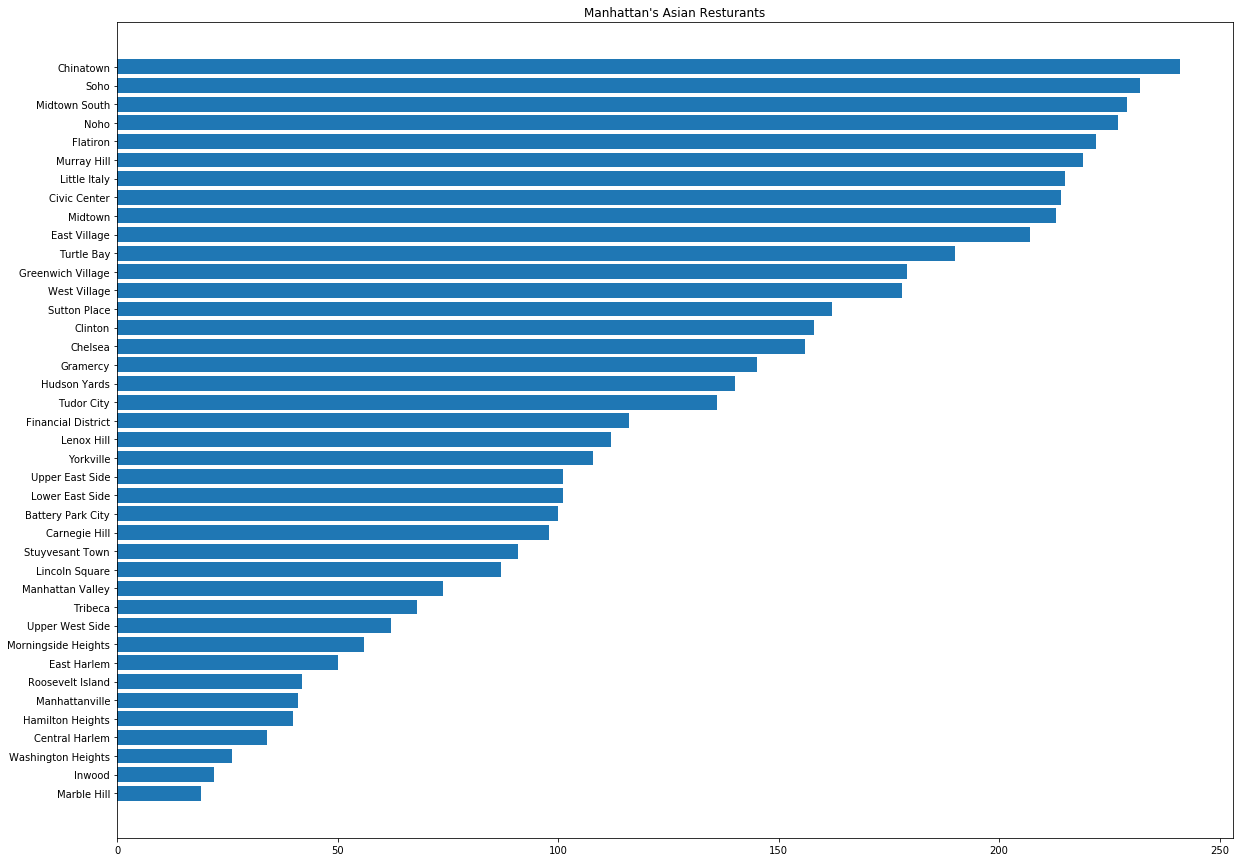

In [29]:
manhattan_venues_df.sort_values(by='Asian Resturants',inplace=True)
plt.figure(figsize=(20,15))
plt.barh(manhattan_venues_df['Neighborhood'],manhattan_venues_df['Asian Resturants'])
plt.title('Manhattan\'s Asian Resturants')

<Figure size 720x432 with 0 Axes>

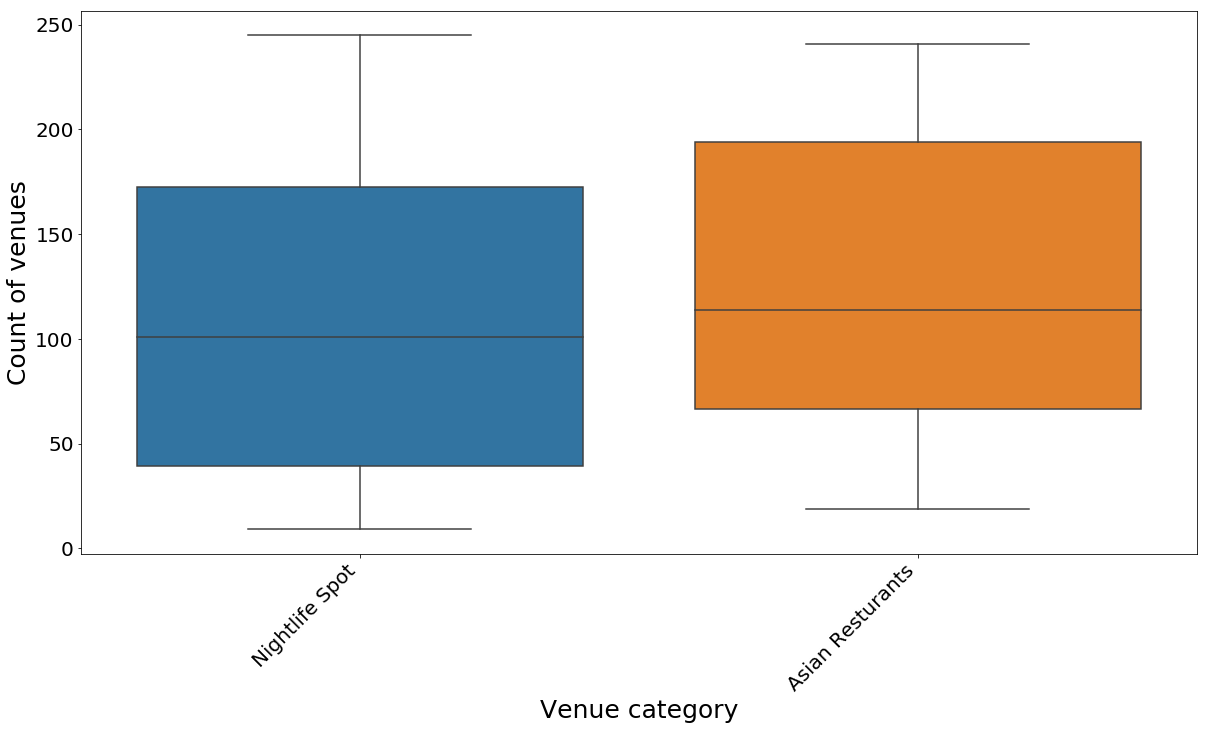

In [30]:
venues_df = manhattan_venues_df.drop(['Latitude','Longitude'], axis=1)

plt.figure(figsize=(10,6))

plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = venues_df)
ax.set_ylabel('Count of venues', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

<h2>Data Preparation

In [31]:
from sklearn.preprocessing import MinMaxScaler

X = manhattan_venues_df.values[:,4:]
cluster_dataset = MinMaxScaler().fit_transform(X)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [32]:
cluster_df = pd.DataFrame(cluster_dataset)
cluster_df.columns = [c[0] for c in categories_list]
cluster_df.head()

,Nightlife Spot,Asian Resturants
0,0.000000,0.000000
1,0.110169,0.013514
2,0.029661,0.031532
3,0.063559,0.067568
4,0.055085,0.094595


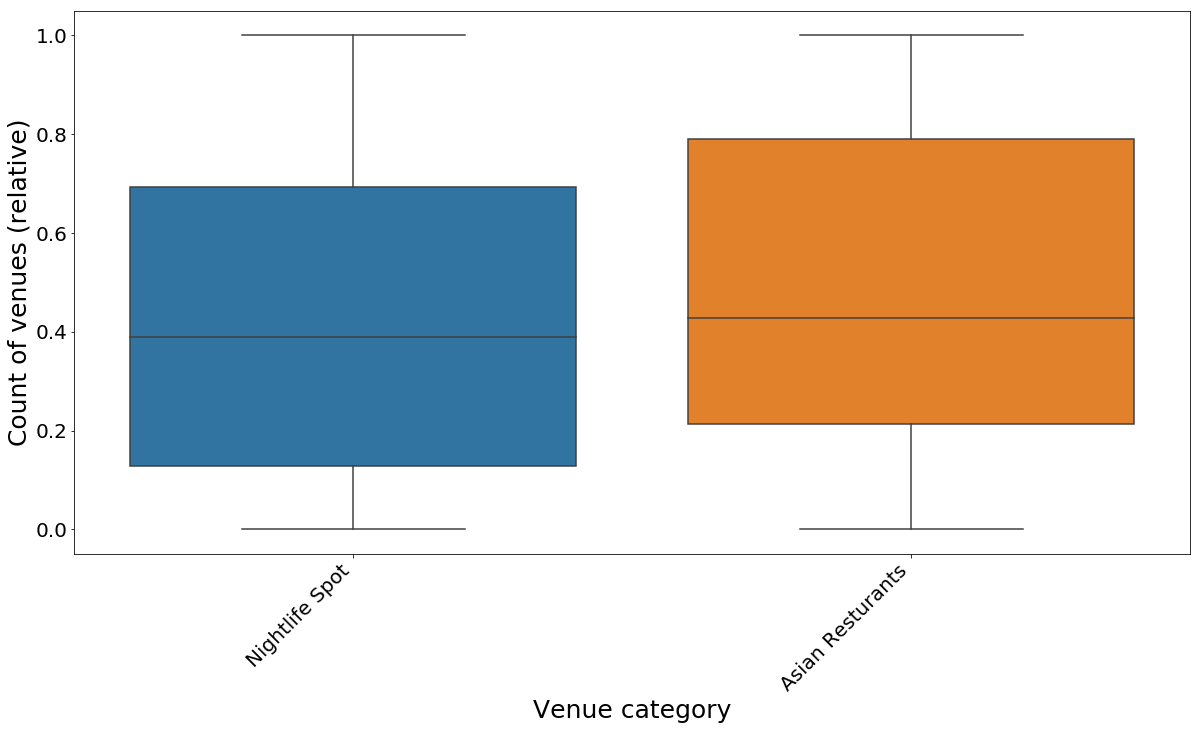

In [33]:
plt.figure(figsize=(20, 10))
#plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = cluster_df)
ax.set_ylabel('Count of venues (relative)', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

<h2>Clustering

In [34]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster_df)

kmeans_labels = kmeans.labels_
# Change label numbers so they go from highest scores to lowest
replace_labels = {0:2, 1:0, 2:3, 3:1}
for i in range(len(kmeans_labels)):
    kmeans_labels[i] = replace_labels[kmeans_labels[i]]

manhattan_clusters_df = manhattan_venues_df.copy()
manhattan_clusters_df['Cluster'] = kmeans_labels
manhattan_clusters_minmax_df = cluster_df.copy()
manhattan_clusters_minmax_df['Cluster'] = kmeans_labels
manhattan_clusters_minmax_df['Neighborhood'] = manhattan_venues_df['Neighborhood']
manhattan_clusters_minmax_df['Longitude'] = manhattan_venues_df['Longitude']
manhattan_clusters_minmax_df['Latitude'] = manhattan_venues_df['Latitude']

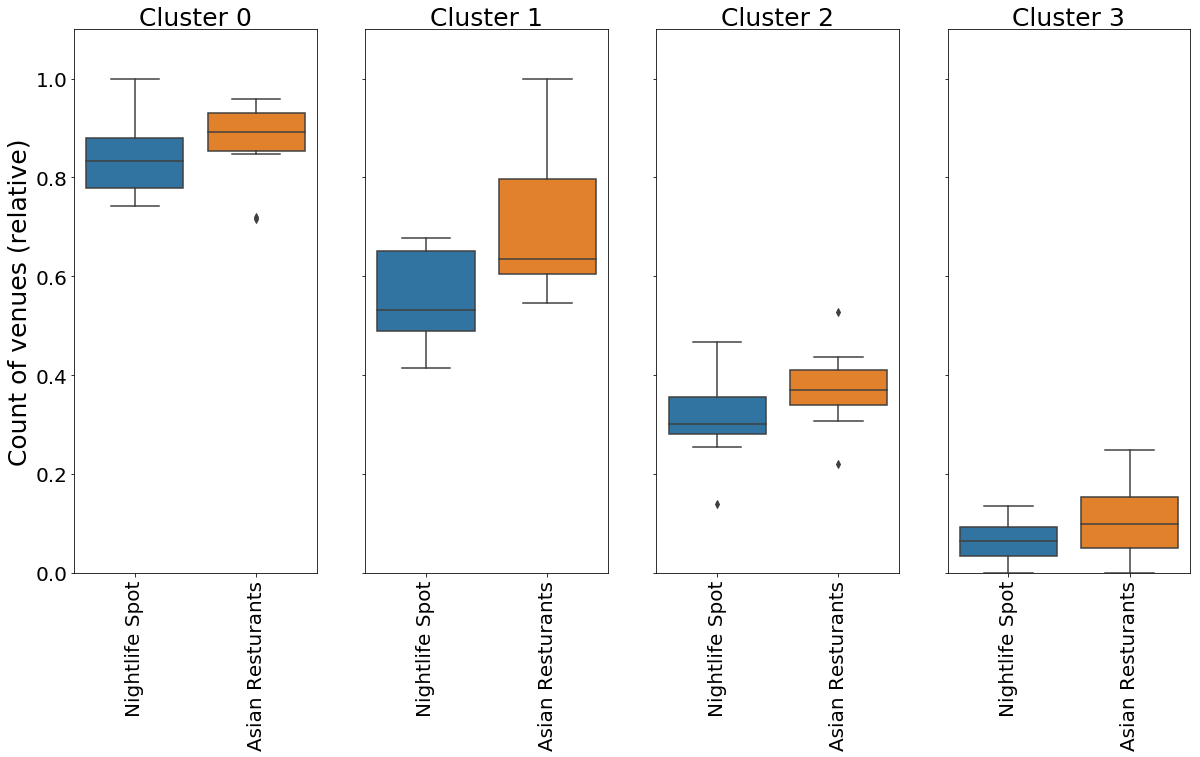

In [35]:
import matplotlib.ticker as ticker

fig, axes = plt.subplots(1,kclusters, figsize=(20, 10), sharey=True)

axes[0].set_ylabel('Count of venues (relative)', fontsize=25)
#plt.set_xlabel('Venue category', fontsize='x-large')

for k in range(kclusters):
    #Set same y axis limits
    axes[k].set_ylim(0,1.1)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k), fontsize=25)
    axes[k].tick_params(labelsize=20)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    sns.boxplot(data = manhattan_clusters_minmax_df[manhattan_clusters_minmax_df['Cluster'] == k].drop(['Cluster','Longitude','Latitude'],1), ax=axes[k])

plt.show()

In [36]:
manhattan_clusters_minmax_df[manhattan_clusters_minmax_df['Cluster'] == 0]

,Nightlife Spot,Asian Resturants,Cluster,Neighborhood,Longitude,Latitude
27,0.830508,0.716216,0,Gramercy,-73.981376,40.737210
28,0.987288,0.720721,0,Battery Park City,-74.016869,40.711932
30,0.745763,0.846847,0,Carnegie Hill,-73.953256,40.782683
31,0.741525,0.873874,0,Noho,-73.988434,40.723259
33,0.775424,0.882883,0,Midtown South,-73.988713,40.748510
34,0.834746,0.900901,0,Sutton Place,-73.963556,40.760280
35,0.834746,0.914414,0,Turtle Bay,-73.967708,40.752042
36,1.000000,0.936937,0,Tudor City,-73.971219,40.746917
37,0.792373,0.945946,0,Stuyvesant Town,-73.974052,40.731000
38,0.894068,0.959459,0,Flatiron,-73.990947,40.739673


In [49]:
import matplotlib.colors as colors

ff = folium.Figure(width=800, height=550)

# create map
map_clusters = folium.Map(location=[40.7896239, -73.9598939], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow = ['green', 'blue', 'yellow', 'red']
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_clusters_minmax_df['Latitude'], manhattan_clusters_minmax_df['Longitude'], manhattan_clusters_minmax_df['Neighborhood'], manhattan_clusters_minmax_df['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
ff.add_child(map_clusters)